In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.datasets import boston_housing
from keras.layers import Dense, Dropout
from keras.utils import multi_gpu_model
from keras import regularizers  # 正则化
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

Using TensorFlow backend.


## 加载数据

In [2]:
(x_train, y_train), (x_valid, y_valid) = boston_housing.load_data()  # 加载数据

# 转成DataFrame格式方便数据处理
x_train_pd = pd.DataFrame(x_train)
y_train_pd = pd.DataFrame(y_train)
x_valid_pd = pd.DataFrame(x_valid)
y_valid_pd = pd.DataFrame(y_valid)
print(x_train_pd.head(5))
print('-------------------')
print(y_train_pd.head(5))

        0     1      2    3      4      5      6       7     8      9     10  \
0  1.23247   0.0   8.14  0.0  0.538  6.142   91.7  3.9769   4.0  307.0  21.0   
1  0.02177  82.5   2.03  0.0  0.415  7.610   15.7  6.2700   2.0  348.0  14.7   
2  4.89822   0.0  18.10  0.0  0.631  4.970  100.0  1.3325  24.0  666.0  20.2   
3  0.03961   0.0   5.19  0.0  0.515  6.037   34.5  5.9853   5.0  224.0  20.2   
4  3.69311   0.0  18.10  0.0  0.713  6.376   88.4  2.5671  24.0  666.0  20.2   

       11     12  
0  396.90  18.72  
1  395.38   3.11  
2  375.52   3.26  
3  396.90   8.01  
4  391.43  14.65  
-------------------
      0
0  15.2
1  42.3
2  50.0
3  21.1
4  17.7


## 数据归一化

In [3]:
# 训练集归一化
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(x_train_pd)
x_train = min_max_scaler.transform(x_train_pd)

min_max_scaler.fit(y_train_pd)
y_train = min_max_scaler.transform(y_train_pd)

# 验证集归一化
min_max_scaler.fit(x_valid_pd)
x_valid = min_max_scaler.transform(x_valid_pd)

min_max_scaler.fit(y_valid_pd)
y_valid = min_max_scaler.transform(y_valid_pd)

print(x_train[0])

[0.01378163 0.         0.28152493 0.         0.31481481 0.49980635
 0.91452111 0.29719123 0.13043478 0.22753346 0.89361702 1.
 0.46881898]


## 训练

In [4]:

# 单CPU or GPU版本，若有GPU则自动切换
model = Sequential()  # 初始化，很重要！
model.add(Dense(units = 10,   # 输出大小
                activation='relu',  # 激励函数
                input_shape=(x_train_pd.shape[1],)  # 输入大小, 也就是列的大小
               )
         )

model.add(Dropout(0.2))  # 丢弃神经元链接概率

model.add(Dense(units = 15,
                kernel_regularizer=regularizers.l2(0.01),  # 施加在权重上的正则项
                activity_regularizer=regularizers.l1(0.01)  # 施加在输出上的正则项
                # activity_regularizer=keras.regularizers.l1_l2(0.01)  # 施加在偏置向量上的正则项
               )
         )

model.add(Dense(units = 1,   
                activation='linear'  # 线性激励函数 回归一般在输出层用这个激励函数  
               )
         )

print(model.summary())  # 打印网络层次结构

model.compile(loss='mse',  # 损失均方误差
              optimizer='adam',  # 优化器
             )

history = model.fit(x_train, y_train,
          epochs=1000,  # 迭代次数
          batch_size=512,  # 每次用来梯度下降的批处理数据大小
          verbose=1,  # verbose：日志冗长度，int：冗长度，0：不输出训练过程，1：偶尔输出，>1：对每个子模型都输出
          validation_data = (x_valid, y_valid)  # 验证集
        )

# 多GPU版本
# parallel_model = multi_gpu_model(model, gpus=4)
# parallel_model.compile(loss='mse',  # 多分类     
#                        optimizer='adam',
#                       )

# This `fit` call will be distributed on 4 GPUs.
# Since the batch size is 50, each GPU will process 32 samples.
# batch_size = 512
# epochs = 2
# history = parallel_model.fit(
#           x_train, 
#           y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_split = 0.2  # 从训练集分割出20%的数据作为验证集
#         )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                140       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                165       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 404 samples, validate on 10

Epoch 62/1000
404/404 [==============================] - 0s 59us/step - loss: 9.2423 - val_loss: 1.7379
Epoch 63/1000
404/404 [==============================] - 0s 52us/step - loss: 9.1327 - val_loss: 1.7194
Epoch 64/1000
404/404 [==============================] - 0s 43us/step - loss: 9.0382 - val_loss: 1.7019
Epoch 65/1000
404/404 [==============================] - 0s 37us/step - loss: 9.0009 - val_loss: 1.6857
Epoch 66/1000
404/404 [==============================] - 0s 44us/step - loss: 8.9398 - val_loss: 1.6704
Epoch 67/1000
404/404 [==============================] - 0s 25us/step - loss: 8.7374 - val_loss: 1.6557
Epoch 68/1000
404/404 [==============================] - 0s 28us/step - loss: 8.5482 - val_loss: 1.6414
Epoch 69/1000
404/404 [==============================] - 0s 41us/step - loss: 8.5642 - val_loss: 1.6273
Epoch 70/1000
404/404 [==============================] - 0s 87us/step - loss: 8.5512 - val_loss: 1.6133
Epoch 71/1000
404/404 [==============================] - 0s 101u

Epoch 141/1000
404/404 [==============================] - 0s 60us/step - loss: 4.6436 - val_loss: 0.9753
Epoch 142/1000
404/404 [==============================] - 0s 83us/step - loss: 4.6559 - val_loss: 0.9702
Epoch 143/1000
404/404 [==============================] - 0s 82us/step - loss: 4.7423 - val_loss: 0.9649
Epoch 144/1000
404/404 [==============================] - 0s 98us/step - loss: 4.5680 - val_loss: 0.9596
Epoch 145/1000
404/404 [==============================] - 0s 108us/step - loss: 4.6151 - val_loss: 0.9541
Epoch 146/1000
404/404 [==============================] - 0s 58us/step - loss: 4.6638 - val_loss: 0.9485
Epoch 147/1000
404/404 [==============================] - 0s 89us/step - loss: 4.5283 - val_loss: 0.9429
Epoch 148/1000
404/404 [==============================] - 0s 88us/step - loss: 4.4531 - val_loss: 0.9373
Epoch 149/1000
404/404 [==============================] - 0s 95us/step - loss: 4.4016 - val_loss: 0.9319
Epoch 150/1000
404/404 [==============================

Epoch 219/1000
404/404 [==============================] - 0s 110us/step - loss: 2.4835 - val_loss: 0.6186
Epoch 220/1000
404/404 [==============================] - 0s 67us/step - loss: 2.4806 - val_loss: 0.6152
Epoch 221/1000
404/404 [==============================] - 0s 82us/step - loss: 2.4405 - val_loss: 0.6117
Epoch 222/1000
404/404 [==============================] - 0s 104us/step - loss: 2.4870 - val_loss: 0.6084
Epoch 223/1000
404/404 [==============================] - 0s 120us/step - loss: 2.4277 - val_loss: 0.6050
Epoch 224/1000
404/404 [==============================] - 0s 101us/step - loss: 2.4059 - val_loss: 0.6016
Epoch 225/1000
404/404 [==============================] - 0s 85us/step - loss: 2.3615 - val_loss: 0.5979
Epoch 226/1000
404/404 [==============================] - 0s 72us/step - loss: 2.3278 - val_loss: 0.5942
Epoch 227/1000
404/404 [==============================] - 0s 77us/step - loss: 2.2978 - val_loss: 0.5906
Epoch 228/1000
404/404 [===========================

Epoch 297/1000
404/404 [==============================] - 0s 115us/step - loss: 1.1640 - val_loss: 0.3676
Epoch 298/1000
404/404 [==============================] - 0s 144us/step - loss: 1.1006 - val_loss: 0.3648
Epoch 299/1000
404/404 [==============================] - 0s 91us/step - loss: 1.1284 - val_loss: 0.3622
Epoch 300/1000
404/404 [==============================] - 0s 117us/step - loss: 1.1218 - val_loss: 0.3595
Epoch 301/1000
404/404 [==============================] - 0s 95us/step - loss: 1.0983 - val_loss: 0.3568
Epoch 302/1000
404/404 [==============================] - 0s 88us/step - loss: 1.0802 - val_loss: 0.3544
Epoch 303/1000
404/404 [==============================] - 0s 66us/step - loss: 1.0784 - val_loss: 0.3517
Epoch 304/1000
404/404 [==============================] - 0s 94us/step - loss: 1.0374 - val_loss: 0.3488
Epoch 305/1000
404/404 [==============================] - 0s 96us/step - loss: 1.0670 - val_loss: 0.3459
Epoch 306/1000
404/404 [============================

Epoch 375/1000
404/404 [==============================] - 0s 80us/step - loss: 0.2382 - val_loss: 0.1643
Epoch 376/1000
404/404 [==============================] - 0s 69us/step - loss: 0.2333 - val_loss: 0.1636
Epoch 377/1000
404/404 [==============================] - 0s 58us/step - loss: 0.2382 - val_loss: 0.1618
Epoch 378/1000
404/404 [==============================] - 0s 42us/step - loss: 0.2270 - val_loss: 0.1613
Epoch 379/1000
404/404 [==============================] - 0s 32us/step - loss: 0.2193 - val_loss: 0.1610
Epoch 380/1000
404/404 [==============================] - 0s 93us/step - loss: 0.2285 - val_loss: 0.1605
Epoch 381/1000
404/404 [==============================] - 0s 94us/step - loss: 0.2157 - val_loss: 0.1585
Epoch 382/1000
404/404 [==============================] - 0s 79us/step - loss: 0.2038 - val_loss: 0.1574
Epoch 383/1000
404/404 [==============================] - 0s 97us/step - loss: 0.1963 - val_loss: 0.1580
Epoch 384/1000
404/404 [==============================]

Epoch 453/1000
404/404 [==============================] - 0s 61us/step - loss: 0.1477 - val_loss: 0.1351
Epoch 454/1000
404/404 [==============================] - 0s 68us/step - loss: 0.1426 - val_loss: 0.1340
Epoch 455/1000
404/404 [==============================] - 0s 78us/step - loss: 0.1388 - val_loss: 0.1332
Epoch 456/1000
404/404 [==============================] - 0s 88us/step - loss: 0.1393 - val_loss: 0.1333
Epoch 457/1000
404/404 [==============================] - 0s 89us/step - loss: 0.1384 - val_loss: 0.1337
Epoch 458/1000
404/404 [==============================] - 0s 87us/step - loss: 0.1393 - val_loss: 0.1326
Epoch 459/1000
404/404 [==============================] - 0s 95us/step - loss: 0.1358 - val_loss: 0.1316
Epoch 460/1000
404/404 [==============================] - 0s 151us/step - loss: 0.1298 - val_loss: 0.1322
Epoch 461/1000
404/404 [==============================] - 0s 59us/step - loss: 0.1336 - val_loss: 0.1326
Epoch 462/1000
404/404 [==============================

Epoch 531/1000
404/404 [==============================] - 0s 88us/step - loss: 0.1238 - val_loss: 0.1224
Epoch 532/1000
404/404 [==============================] - 0s 56us/step - loss: 0.1172 - val_loss: 0.1223
Epoch 533/1000
404/404 [==============================] - 0s 58us/step - loss: 0.1183 - val_loss: 0.1236
Epoch 534/1000
404/404 [==============================] - 0s 58us/step - loss: 0.1250 - val_loss: 0.1242
Epoch 535/1000
404/404 [==============================] - 0s 48us/step - loss: 0.1251 - val_loss: 0.1234
Epoch 536/1000
404/404 [==============================] - 0s 64us/step - loss: 0.1247 - val_loss: 0.1218
Epoch 537/1000
404/404 [==============================] - 0s 34us/step - loss: 0.1181 - val_loss: 0.1214
Epoch 538/1000
404/404 [==============================] - 0s 70us/step - loss: 0.1170 - val_loss: 0.1220
Epoch 539/1000
404/404 [==============================] - 0s 108us/step - loss: 0.1197 - val_loss: 0.1222
Epoch 540/1000
404/404 [==============================

Epoch 609/1000
404/404 [==============================] - 0s 59us/step - loss: 0.1112 - val_loss: 0.1160
Epoch 610/1000
404/404 [==============================] - 0s 64us/step - loss: 0.1122 - val_loss: 0.1160
Epoch 611/1000
404/404 [==============================] - 0s 45us/step - loss: 0.1117 - val_loss: 0.1159
Epoch 612/1000
404/404 [==============================] - 0s 34us/step - loss: 0.1112 - val_loss: 0.1159
Epoch 613/1000
404/404 [==============================] - 0s 35us/step - loss: 0.1118 - val_loss: 0.1159
Epoch 614/1000
404/404 [==============================] - 0s 54us/step - loss: 0.1104 - val_loss: 0.1163
Epoch 615/1000
404/404 [==============================] - 0s 63us/step - loss: 0.1141 - val_loss: 0.1162
Epoch 616/1000
404/404 [==============================] - 0s 76us/step - loss: 0.1138 - val_loss: 0.1158
Epoch 617/1000
404/404 [==============================] - 0s 85us/step - loss: 0.1096 - val_loss: 0.1158
Epoch 618/1000
404/404 [==============================]

Epoch 687/1000
404/404 [==============================] - 0s 46us/step - loss: 0.1079 - val_loss: 0.1113
Epoch 688/1000
404/404 [==============================] - 0s 30us/step - loss: 0.1072 - val_loss: 0.1110
Epoch 689/1000
404/404 [==============================] - 0s 21us/step - loss: 0.1057 - val_loss: 0.1106
Epoch 690/1000
404/404 [==============================] - 0s 26us/step - loss: 0.1054 - val_loss: 0.1114
Epoch 691/1000
404/404 [==============================] - 0s 23us/step - loss: 0.1072 - val_loss: 0.1110
Epoch 692/1000
404/404 [==============================] - 0s 26us/step - loss: 0.1073 - val_loss: 0.1107
Epoch 693/1000
404/404 [==============================] - 0s 36us/step - loss: 0.1054 - val_loss: 0.1107
Epoch 694/1000
404/404 [==============================] - 0s 24us/step - loss: 0.1064 - val_loss: 0.1101
Epoch 695/1000
404/404 [==============================] - 0s 56us/step - loss: 0.1043 - val_loss: 0.1100
Epoch 696/1000
404/404 [==============================]

Epoch 765/1000
404/404 [==============================] - 0s 36us/step - loss: 0.1038 - val_loss: 0.1064
Epoch 766/1000
404/404 [==============================] - 0s 39us/step - loss: 0.1012 - val_loss: 0.1057
Epoch 767/1000
404/404 [==============================] - 0s 39us/step - loss: 0.0981 - val_loss: 0.1061
Epoch 768/1000
404/404 [==============================] - 0s 36us/step - loss: 0.1005 - val_loss: 0.1064
Epoch 769/1000
404/404 [==============================] - 0s 48us/step - loss: 0.1004 - val_loss: 0.1058
Epoch 770/1000
404/404 [==============================] - 0s 79us/step - loss: 0.0994 - val_loss: 0.1058
Epoch 771/1000
404/404 [==============================] - 0s 137us/step - loss: 0.0989 - val_loss: 0.1060
Epoch 772/1000
404/404 [==============================] - 0s 70us/step - loss: 0.0992 - val_loss: 0.1056
Epoch 773/1000
404/404 [==============================] - 0s 117us/step - loss: 0.0992 - val_loss: 0.1061
Epoch 774/1000
404/404 [=============================

Epoch 843/1000
404/404 [==============================] - 0s 30us/step - loss: 0.0993 - val_loss: 0.1028
Epoch 844/1000
404/404 [==============================] - 0s 31us/step - loss: 0.0991 - val_loss: 0.1033
Epoch 845/1000
404/404 [==============================] - 0s 29us/step - loss: 0.1013 - val_loss: 0.1032
Epoch 846/1000
404/404 [==============================] - 0s 41us/step - loss: 0.1009 - val_loss: 0.1022
Epoch 847/1000
404/404 [==============================] - 0s 33us/step - loss: 0.0971 - val_loss: 0.1018
Epoch 848/1000
404/404 [==============================] - 0s 23us/step - loss: 0.0957 - val_loss: 0.1028
Epoch 849/1000
404/404 [==============================] - 0s 29us/step - loss: 0.0997 - val_loss: 0.1031
Epoch 850/1000
404/404 [==============================] - 0s 45us/step - loss: 0.1011 - val_loss: 0.1025
Epoch 851/1000
404/404 [==============================] - 0s 54us/step - loss: 0.0984 - val_loss: 0.1026
Epoch 852/1000
404/404 [==============================]

Epoch 921/1000
404/404 [==============================] - 0s 78us/step - loss: 0.0930 - val_loss: 0.0986
Epoch 922/1000
404/404 [==============================] - 0s 146us/step - loss: 0.0936 - val_loss: 0.0983
Epoch 923/1000
404/404 [==============================] - 0s 49us/step - loss: 0.0911 - val_loss: 0.0983
Epoch 924/1000
404/404 [==============================] - 0s 41us/step - loss: 0.0921 - val_loss: 0.0984
Epoch 925/1000
404/404 [==============================] - 0s 31us/step - loss: 0.0929 - val_loss: 0.0983
Epoch 926/1000
404/404 [==============================] - 0s 36us/step - loss: 0.0914 - val_loss: 0.0983
Epoch 927/1000
404/404 [==============================] - 0s 39us/step - loss: 0.0927 - val_loss: 0.0985
Epoch 928/1000
404/404 [==============================] - 0s 35us/step - loss: 0.0935 - val_loss: 0.0981
Epoch 929/1000
404/404 [==============================] - 0s 34us/step - loss: 0.0920 - val_loss: 0.0979
Epoch 930/1000
404/404 [==============================

Epoch 999/1000
404/404 [==============================] - 0s 64us/step - loss: 0.0913 - val_loss: 0.0961
Epoch 1000/1000
404/404 [==============================] - 0s 108us/step - loss: 0.0936 - val_loss: 0.0960


## 训练过程可视化

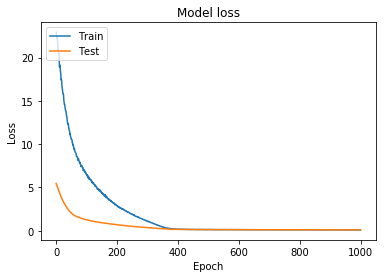

In [5]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 保存模型 & 模型可视化 & 加载模型

In [7]:
from keras.utils import plot_model
from keras.models import load_model
# 保存模型
model.save('model_MLP.h5')  # creates a HDF5 file 'my_model.h5'

#模型可视化
plot_model(model, to_file='model_MLP.png', show_shapes=True)

# 加载模型
model = load_model('model_MLP.h5')